In [1]:
import nltk
import urduhack
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
urdu_doc = pd.read_csv('C:/Users/EMAAZ/Desktop/Dataset/UrduReview.csv' , encoding ='utf8')

In [3]:
urdu_doc = urdu_doc.dropna()
urdu_doc.shape

(50000, 2)

In [4]:
urdu_doc.head()

,review,sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,1
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,0
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,1
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,0
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,1


In [5]:
urdu_doc['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [6]:
# Encode the labels
df = urdu_doc
le = LabelEncoder()
le.fit(df['sentiment'])
df['encoded_sentiments'] = le.transform(df['sentiment'])

In [7]:
def removing_unwanted_data(text):
    
    #format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ',text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r"[:؛؟’‘٭ء،۔]+", " ", text)
    text = re.sub(r"[٠‎١‎٢‎٣‎٤‎٥‎٦‎٧‎٨‎٩]+", " ", text)
    text = re.sub(r"[a-zA-z0-9]+", " ", text)
    
    text = nltk.WordPunctTokenizer().tokenize(text)
    
    return text

In [8]:
urdu_doc['text_cleaned']= list(map(removing_unwanted_data,urdu_doc.review)) #map -> name and data send in func

In [9]:
urdu_doc.head()

,review,sentiment,encoded_sentiments,text_cleaned
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,1,1,"[میں, نے, اسے, کی, دہائی, کے, وسط, میں, ایک, ک..."
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,0,0,"[چونکہ, میں, نے, کی, دہائی, میں, انسپکٹر, گیجٹ..."
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,1,1,"[ایک, ایسے, معاشرے, کی, حالت, کے, بارے, میں, ت..."
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,0,0,"[مفید, البرٹ, پیون, کی, طرف, سے, ایک, اور, ردی..."
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,1,1,"[یہ, کولمبو, ہے, جس, کی, ہدایتکاری, اپنے, کیری..."


In [10]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

In [11]:
from urduhack.models.lemmatizer import lemmatizer
def lemitizeStr(str):
    lemme_str = " "
    temp = lemmatizer.lemma_lookup(str)
    for t in temp:
        lemme_str += t[0] + " "
    
    return lemme_str

In [12]:
df['review'] =  df['review'].apply(remove_stopwords)

In [13]:
df['lemmatized_text'] = df['review'].apply(lemitizeStr)

In [14]:
urdu_doc.head()

,review,sentiment,encoded_sentiments,text_cleaned,lemmatized_text
0,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...,1,1,"[میں, نے, اسے, کی, دہائی, کے, وسط, میں, ایک, ک...",80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو ا...
1,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...,0,0,"[چونکہ, میں, نے, کی, دہائی, میں, انسپکٹر, گیجٹ...",80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھن...
2,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,1,1,"[ایک, ایسے, معاشرے, کی, حالت, کے, بارے, میں, ت...",معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ...
3,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...,0,0,"[مفید, البرٹ, پیون, کی, طرف, سے, ایک, اور, ردی...",مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم ت...
4,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,1,1,"[یہ, کولمبو, ہے, جس, کی, ہدایتکاری, اپنے, کیری...",کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اس...


In [15]:
print("Samples per class: {}".format(np.bincount(urdu_doc.encoded_sentiments)))

Samples per class: [25000 25000]


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(df['lemmatized_text'], df['encoded_sentiments'], test_size = 0.30, random_state = 7)

In [17]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of Y_train', Y_train.shape)
print('Shape of Y_test', Y_test.shape)

Shape of X_train (35000,)
Shape of X_test (15000,)
Shape of Y_train (35000,)
Shape of Y_test (15000,)


In [18]:
BOW_convert = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = BOW_convert.fit_transform(df['lemmatized_text'])

words = BOW_convert.get_feature_names()
print("The total number of columns are =",len(words))
print('Shape of arrays =',x.toarray().shape)

The total number of columns are = 303
Shape of arrays = (50000, 303)


In [19]:
import sklearn.model_selection

train,test= sklearn.model_selection.train_test_split(df, train_size = 0.7, random_state=4) #Split and Shuffle

print('Training data set shape =',train.shape)
print('Testing data set shape =', test.shape)

Training data set shape = (35000, 5)
Testing data set shape = (15000, 5)


In [20]:
BOW_convert = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

X_train = BOW_convert.fit_transform(train['lemmatized_text'])

X_test = BOW_convert.transform(test['lemmatized_text'])

Y_train=train['encoded_sentiments']
Y_test=test['encoded_sentiments']
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(35000, 282)
(35000,)
(15000, 282)
(15000,)


### DECISION TREE

In [21]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()

In [22]:
model_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
y_prob = model_tree.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_tree.score(X_test, y_pred)

1.0

In [26]:
confusion_matrix=metrics.confusion_matrix(Y_test,y_pred)
confusion_matrix

array([[4223, 3266],
       [3304, 4207]], dtype=int64)

In [27]:
auc_roc=metrics.classification_report(Y_test,y_pred)
auc_roc

'              precision    recall  f1-score   support\n\n           0       0.56      0.56      0.56      7489\n           1       0.56      0.56      0.56      7511\n\n    accuracy                           0.56     15000\n   macro avg       0.56      0.56      0.56     15000\nweighted avg       0.56      0.56      0.56     15000\n'

In [28]:
auc_roc=metrics.roc_auc_score(Y_test,y_pred)
auc_roc

0.5620027733748547

In [29]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

Text(0.5, 0, 'False Positive Rate')

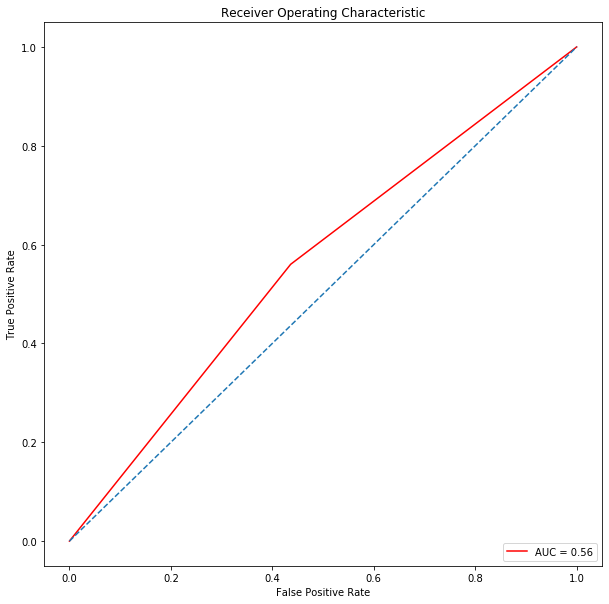

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Tuned Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

model_DD = DecisionTreeClassifier()


tuned_parameters= {'criterion': ['gini','entropy'], 'max_features': ["auto","sqrt","log2"],
                   'min_samples_leaf': range(1,100,1) , 'max_depth': range(1,50,1)
                  }

In [32]:
DD_model= RandomizedSearchCV(model_DD, tuned_parameters,cv=45,scoring='accuracy',n_iter=10,n_jobs= -1,random_state=5)

In [33]:
DD_model.fit(X_train, Y_train)

RandomizedSearchCV(cv=45, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best'

In [34]:
print(DD_model.best_score_)

0.5793714285714285


In [35]:
print(DD_model.best_params_)

{'min_samples_leaf': 77, 'max_features': 'auto', 'max_depth': 11, 'criterion': 'gini'}


In [36]:
y_prob = DD_model.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
DD_model.score(X_test, y_pred)

1.0

In [37]:
confusion_matrix=metrics.confusion_matrix(Y_test,y_pred)
confusion_matrix

array([[4366, 3123],
       [3216, 4295]], dtype=int64)

In [38]:
auc_roc=metrics.classification_report(Y_test,y_pred)
auc_roc

'              precision    recall  f1-score   support\n\n           0       0.58      0.58      0.58      7489\n           1       0.58      0.57      0.58      7511\n\n    accuracy                           0.58     15000\n   macro avg       0.58      0.58      0.58     15000\nweighted avg       0.58      0.58      0.58     15000\n'

In [39]:
auc_roc=metrics.roc_auc_score(Y_test,y_pred)
auc_roc

0.5774081842913831

In [40]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6099675521079787

Text(0.5, 0, 'False Positive Rate')

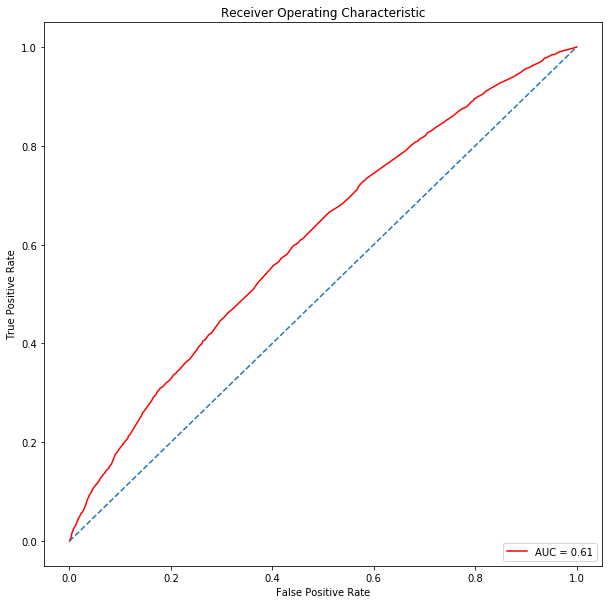

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')